In the last model I scaled the output between 0 and 1. I also made some changes to network architecture. I was able to work my way up to a 60% test score. In this model, I will implement further tweaks to try to increase the score. I added 10000 more positive examples. I will also let the model train overnight over a long epoch to see if there is any continuing improvement.

In [1]:
%load_ext autoreload
%autoreload 2
import project_utils_multi

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
# tf.get_logger().setLevel('INFO')
# tf.autograph.set_verbosity(1)
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device. Error.')
    pass

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from random import randint
import numpy as np

RANDOM_SEED = 0
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 200
LEARNING_RATE = 0.00005
ES_PATIENCE = 20
ES_RESTORE_WEIGHTS = True
PLAY_VIDEOS = True
PLAY_DATA_VIDEOS = False

In [2]:
df_train = project_utils_multi.load_image_dataframes('./data/train/', 'annotations.json')
display(df_train)
df_train['y1'] = df_train['y1'] / project_utils_multi.ORIGINAL_IMAGE_HEIGHT
df_train['x1'] = df_train['x1'] / project_utils_multi.ORIGINAL_IMAGE_WIDTH
df_train['y2'] = df_train['y2'] / project_utils_multi.ORIGINAL_IMAGE_HEIGHT
df_train['x2'] = df_train['x2'] / project_utils_multi.ORIGINAL_IMAGE_WIDTH
display(df_train)

id  confidence     y1     x1     y2     x2
0      00001.jpg         1.0  152.0  140.0  397.0  346.0
1      00002.jpg         1.0  144.0  140.0  403.0  345.0
2      00003.jpg         1.0  142.0  138.0  402.0  346.0
3      00004.jpg         1.0  144.0  140.0  405.0  344.0
4      00005.jpg         1.0  141.0  140.0  407.0  344.0
...          ...         ...    ...    ...    ...    ...
45993  45994.jpg         0.0    0.0    0.0    0.0    0.0
45994  45995.jpg         0.0    0.0    0.0    0.0    0.0
45995  45996.jpg         0.0    0.0    0.0    0.0    0.0
45996  45997.jpg         0.0    0.0    0.0    0.0    0.0
45997  45998.jpg         0.0    0.0    0.0    0.0    0.0

[45998 rows x 6 columns]

id  confidence        y1        x1        y2        x2
0      00001.jpg         1.0  0.211111  0.145833  0.551389  0.360417
1      00002.jpg         1.0  0.200000  0.145833  0.559722  0.359375
2      00003.jpg         1.0  0.197222  0.143750  0.558333  0.360417
3      00004.jpg         1.0  0.200000  0.145833  0.562500  0.358333
4      00005.jpg         1.0  0.195833  0.145833  0.565278  0.358333
...          ...         ...       ...       ...       ...       ...
45993  45994.jpg         0.0  0.000000  0.000000  0.000000  0.000000
45994  45995.jpg         0.0  0.000000  0.000000  0.000000  0.000000
45995  45996.jpg         0.0  0.000000  0.000000  0.000000  0.000000
45996  45997.jpg         0.0  0.000000  0.000000  0.000000  0.000000
45997  45998.jpg         0.0  0.000000  0.000000  0.000000  0.000000

[45998 rows x 6 columns]

In [3]:
df_validation = project_utils_multi.load_image_dataframes('./data/validation/', 'annotations.json')
display(df_validation)
df_validation['y1'] = df_validation['y1'] / project_utils_multi.ORIGINAL_IMAGE_HEIGHT
df_validation['x1'] = df_validation['x1'] / project_utils_multi.ORIGINAL_IMAGE_WIDTH
df_validation['y2'] = df_validation['y2'] / project_utils_multi.ORIGINAL_IMAGE_HEIGHT
df_validation['x2'] = df_validation['x2'] / project_utils_multi.ORIGINAL_IMAGE_WIDTH
display(df_validation)

id  confidence     y1     x1     y2     x2
0    00001.jpg         1.0  439.0  600.0  630.0  804.0
1    00002.jpg         1.0  280.0  466.0  467.0  650.0
2    00003.jpg         1.0  204.0  455.0  409.0  636.0
3    00004.jpg         1.0  218.0  380.0  412.0  538.0
4    00005.jpg         1.0  220.0  405.0  423.0  568.0
..         ...         ...    ...    ...    ...    ...
305  00306.jpg         0.0    0.0    0.0    0.0    0.0
306  00307.jpg         0.0    0.0    0.0    0.0    0.0
307  00308.jpg         0.0    0.0    0.0    0.0    0.0
308  00309.jpg         0.0    0.0    0.0    0.0    0.0
309  00310.jpg         0.0    0.0    0.0    0.0    0.0

[310 rows x 6 columns]

id  confidence        y1        x1        y2        x2
0    00001.jpg         1.0  0.609722  0.625000  0.875000  0.837500
1    00002.jpg         1.0  0.388889  0.485417  0.648611  0.677083
2    00003.jpg         1.0  0.283333  0.473958  0.568056  0.662500
3    00004.jpg         1.0  0.302778  0.395833  0.572222  0.560417
4    00005.jpg         1.0  0.305556  0.421875  0.587500  0.591667
..         ...         ...       ...       ...       ...       ...
305  00306.jpg         0.0  0.000000  0.000000  0.000000  0.000000
306  00307.jpg         0.0  0.000000  0.000000  0.000000  0.000000
307  00308.jpg         0.0  0.000000  0.000000  0.000000  0.000000
308  00309.jpg         0.0  0.000000  0.000000  0.000000  0.000000
309  00310.jpg         0.0  0.000000  0.000000  0.000000  0.000000

[310 rows x 6 columns]

In [4]:
df_test = project_utils_multi.load_image_dataframes('./data/test/', 'annotations.json')
display(df_test)
df_test['y1'] = df_test['y1'] / project_utils_multi.ORIGINAL_IMAGE_HEIGHT
df_test['x1'] = df_test['x1'] / project_utils_multi.ORIGINAL_IMAGE_WIDTH
df_test['y2'] = df_test['y2'] / project_utils_multi.ORIGINAL_IMAGE_HEIGHT
df_test['x2'] = df_test['x2'] / project_utils_multi.ORIGINAL_IMAGE_WIDTH
display(df_test)

id  confidence     y1     x1     y2     x2
0    00001.jpg         1.0  220.0  252.0  411.0  437.0
1    00002.jpg         1.0  217.0  241.0  402.0  432.0
2    00003.jpg         1.0  229.0  252.0  416.0  443.0
3    00004.jpg         1.0  243.0  317.0  425.0  487.0
4    00005.jpg         1.0  274.0  332.0  457.0  510.0
..         ...         ...    ...    ...    ...    ...
219  00220.jpg         0.0    0.0    0.0    0.0    0.0
220  00221.jpg         0.0    0.0    0.0    0.0    0.0
221  00222.jpg         0.0    0.0    0.0    0.0    0.0
222  00223.jpg         0.0    0.0    0.0    0.0    0.0
223  00224.jpg         0.0    0.0    0.0    0.0    0.0

[224 rows x 6 columns]

id  confidence        y1        x1        y2        x2
0    00001.jpg         1.0  0.305556  0.262500  0.570833  0.455208
1    00002.jpg         1.0  0.301389  0.251042  0.558333  0.450000
2    00003.jpg         1.0  0.318056  0.262500  0.577778  0.461458
3    00004.jpg         1.0  0.337500  0.330208  0.590278  0.507292
4    00005.jpg         1.0  0.380556  0.345833  0.634722  0.531250
..         ...         ...       ...       ...       ...       ...
219  00220.jpg         0.0  0.000000  0.000000  0.000000  0.000000
220  00221.jpg         0.0  0.000000  0.000000  0.000000  0.000000
221  00222.jpg         0.0  0.000000  0.000000  0.000000  0.000000
222  00223.jpg         0.0  0.000000  0.000000  0.000000  0.000000
223  00224.jpg         0.0  0.000000  0.000000  0.000000  0.000000

[224 rows x 6 columns]

In [5]:
train_datagen= project_utils_multi.create_data_generators(df_train, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/train/', seed=RANDOM_SEED)
validation_datagen = project_utils_multi.create_data_generators(df_validation, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/validation/', seed=RANDOM_SEED)
test_datagen = project_utils_multi.create_data_generators(df_test, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/test/', seed=RANDOM_SEED)
if PLAY_DATA_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, num_to_iter=250))
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, num_to_iter=1))
    display(project_utils_multi.play_images_from_sequence_datagen(test_datagen, num_to_iter=1))

In [6]:
pos_neg = project_utils_multi.get_negative_positive_count('./data/train/', 'annotations.json')
print('Total Examples: ', pos_neg['positive'] + pos_neg['negative'])
print('Total positive: ', pos_neg['positive'])
print('Total negative: ', pos_neg['negative'])
print('Train positive: ', train_datagen.get_positive_count())
print('Train negative: ', train_datagen.get_negative_count())
print('Validation positive: ', validation_datagen.get_positive_count())
print('Validation negative: ', validation_datagen.get_negative_count())
print('Test positive: ', test_datagen.get_positive_count())
print('Test negative: ', test_datagen.get_negative_count())

Total Examples:  45998
Total positive:  35398
Total negative:  10600
Train positive:  35398
Train negative:  10600
Validation positive:  262
Validation negative:  48
Test positive:  202
Test negative:  22


In [7]:
vgg = keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))
vgg.trainable = False
flatten = vgg.output
flatten = keras.layers.Flatten()(flatten)


hidden = keras.layers.Dense(1024, activation='relu')(flatten)
hidden = keras.layers.Dropout(0.1)(hidden)
hidden = keras.layers.Dense(512, activation='relu')(hidden)
hidden = keras.layers.Dropout(0.1)(hidden)
hidden = keras.layers.Dense(256, activation='relu')(hidden)
hidden = keras.layers.Dropout(0.1)(hidden)


confHead = keras.layers.Dense(1, activation='sigmoid', name='confidence_output')(hidden)
bbHead = keras.layers.Dense(4, activation='sigmoid', name='bounding_output')(hidden)

model = keras.models.Model(inputs=vgg.input, outputs=[confHead, bbHead])

opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# opt = keras.optimizers.Adam()

model.compile(loss='mse', optimizer=opt, metrics=[[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()], [project_utils_multi.IOU_Metric()]])#, run_eagerly=True)


es = EarlyStopping(monitor='val_bounding_output_iou__metric', mode='max', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)
# es = EarlyStopping(monitor='val_bounding_output_loss', mode='min', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)

history = model.fit(train_datagen, 
                    steps_per_epoch=train_datagen.get_length() // BATCH_SIZE,
                    validation_data=validation_datagen, 
                    validation_steps = validation_datagen.get_length() // BATCH_SIZE,
                    epochs=EPOCHS, 
                    callbacks=[es])


80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/200
1437/1437 [==============================] - 301s 201ms/step - loss: 0.0556 - confidence_output_loss: 0.0307 - bounding_output_loss: 0.0249 - confidence_output_binary_accuracy: 0.9582 - confidence_output_auc: 0.9805 - bounding_output_iou__metric: 0.3811 - val_loss: 0.0091 - val_confidence_output_loss: 0.0046 - val_bounding_output_loss: 0.0046 - val_confidence_output_binary_accuracy: 0.9931 - val_confidence_output_auc: 0.9999 - val_bounding_output_iou__metric: 0.5050
Epoch 2/200
1437/1437 [==============================] - 277s 193ms/step - loss: 0.0081 - confidence_output_loss: 0.0028 - bounding_output_loss: 0.0053 - confidence_output_binary_accuracy: 0.9967 - confidence_output_auc: 0.9999 - bounding_output_iou__metric: 0.5331 - val_loss: 0.0144 - val_confidence_output_loss: 0.0082 - val_bounding_output_loss: 0.0062 - val_confidence_output_binary_accuracy: 0.9861 - val_confidence_output_auc: 0.9998 - val_bound

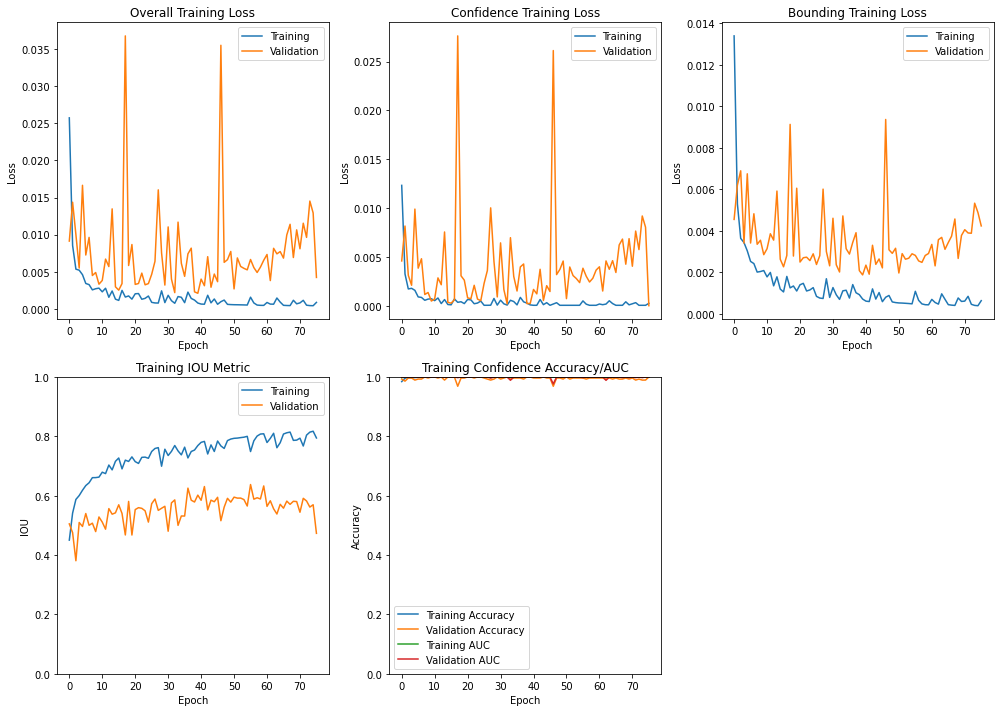

7/7 [==============================] - 1s 179ms/step - loss: 0.0077 - confidence_output_loss: 0.0045 - bounding_output_loss: 0.0032 - confidence_output_binary_accuracy: 0.9955 - confidence_output_auc: 0.9975 - bounding_output_iou__metric: 0.6412
Training Loss: 0.0003525509382598102
Training IOU: 0.8389637470245361
Validation Loss: 0.0066839600913226604
Validation IOU: 0.634175717830658
Test Loss: 0.007683258969336748
Test IOU: 0.6411762237548828


In [8]:
project_utils_multi.plot_history(history)
train_results = model.evaluate(train_datagen)
validation_results = model.evaluate(validation_datagen)
test_results = model.evaluate(test_datagen)
print('Training Loss: {}\nTraining IOU: {}'.format(train_results[0], train_results[-1]))
print('Validation Loss: {}\nValidation IOU: {}'.format(validation_results[0], validation_results[-1]))
print('Test Loss: {}\nTest IOU: {}'.format(test_results[0], test_results[-1]))
project_utils_multi.write_results('./history.txt', model, history, train_datagen, validation_datagen, train_results, validation_results, test_results)

In [9]:
project_utils_multi.append_score_data('./scores.txt', model, train_datagen, history, es, train_results, validation_results, test_results)

In [10]:
model.save('./saves/last_model.h5')

In [11]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, model=model, num_to_iter=100, scaled_targets=True))

In [12]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, model=model, num_to_iter=1, scaled_targets=True))

In [13]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(test_datagen, model=model, num_to_iter=1, scaled_targets=True))

In [14]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/videos/hand_signs_hand_only.mp4', model=model, scaled_targets=True))

In [15]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/videos/hand_signs_webcam.mp4', model=model, scaled_targets=True))